#Revised EBTEL Analysis Scripts

Testing reorganized EBTEL analysis scripts as well as addition of new features.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append('/home/wtb2/Documents/EBTEL_analysis/src/')
import ebtel_dem as ebd
import ebtel_plot_em as ebpe
from imp import reload
reload(ebd)
reload(ebpe)

/usr/local/lib/python3.4/dist-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'ebtel_plot_em' from '/home/wtb2/Documents/EBTEL_analysis/src/ebtel_plot_em.py'>

First, set some basic parameters regarding what data set we want to load in.

In [2]:
root_dir = '/data/datadrive2/EBTEL-2fluid_runs/'
species = 'electron'
tpulse = 100.0
alpha = 1.5
loop_length = 40.0
solver = 'rka4'
Tn = np.arange(250,5250,250)

Now, instantiate the DEMProcess class and import data and compute statistics.

In [3]:
process = ebd.DEMProcess(root_dir,species,alpha,loop_length,tpulse,solver,verbose=True)

In [4]:
process.import_raw(Tn)

Unable to process file for Tn = 250, run = 44
Reached end of list or there was an error reading the file.
Unable to process file for Tn = 500, run = 75
Reached end of list or there was an error reading the file.
Unable to process file for Tn = 750, run = 106
Reached end of list or there was an error reading the file.
Unable to process file for Tn = 1000, run = 137
Reached end of list or there was an error reading the file.
Unable to process file for Tn = 1250, run = 167
Reached end of list or there was an error reading the file.
Unable to process file for Tn = 1500, run = 200
Reached end of list or there was an error reading the file.
Unable to process file for Tn = 1750, run = 228
Reached end of list or there was an error reading the file.
Unable to process file for Tn = 2000, run = 257
Reached end of list or there was an error reading the file.
Unable to process file for Tn = 2250, run = 286
Reached end of list or there was an error reading the file.
Unable to process file for Tn = 2

In [5]:
process.calc_stats()
process.interp_and_filter()

Next, instantiate the Analyze class and feed it the processed $\mathrm{EM}$ and $T$ arrays.

In [6]:
slope_limits = {'cool_lower':6.0,'cool_upper':6.6,'hot_lower':6.8,'hot_upper':7.3}
analyze = ebd.DEMAnalyze(process.em_mean,process.temp_mean,process.em_std,verbose=True,slope_limits=slope_limits)

In [7]:
analyze.many_fits()

Cool bound out of range, T = 6.40 > T_limit = 6.00
or T_upper_limit = 6.60 > T_max = 6.80
Hot bound out of range, T = 7.03 < T_limit = 7.30
or T_lower_limit = 6.80 < T_max = 6.60
Cool bound out of range, T = 6.33 > T_limit = 6.00
or T_upper_limit = 6.60 > T_max = 6.80
Hot bound out of range, T = 7.11 < T_limit = 7.30
or T_lower_limit = 6.80 < T_max = 6.60
Cool bound out of range, T = 6.28 > T_limit = 6.00
or T_upper_limit = 6.60 > T_max = 6.80
Hot bound out of range, T = 7.18 < T_limit = 7.30
or T_lower_limit = 6.80 < T_max = 6.60
Cool bound out of range, T = 6.22 > T_limit = 6.00
or T_upper_limit = 6.60 > T_max = 6.80
Hot bound out of range, T = 7.23 < T_limit = 7.30
or T_lower_limit = 6.80 < T_max = 6.60
Cool bound out of range, T = 6.15 > T_limit = 6.00
or T_upper_limit = 6.60 > T_max = 6.80
Hot bound out of range, T = 7.28 < T_limit = 7.30
or T_lower_limit = 6.80 < T_max = 6.60
Hot bound out of range, T = 7.28 < T_limit = 7.30
or T_lower_limit = 6.80 < T_max = 6.60


Next, we'll build our fit line parameter dictionaries so we can plot the fit lines on top of our emission curves.

In [8]:
t_cool = []
t_hot = []
for i in range(len(analyze.hot_fits)):
    t_cool.append(np.linspace(slope_limits['cool_lower'],slope_limits['cool_upper'],100))
    t_hot.append(np.linspace(slope_limits['hot_lower'],slope_limits['hot_upper'],100))
    
fit_lines = {'t_cool':t_cool,'t_hot':t_hot}

Now, plot the emission curves with superimposed fit lines and fit line slopes

In [9]:
plotter = ebpe.DEMPlotter(process.temp_em,process.em,process.temp_mean,process.em_mean,process.em_std,analyze.cool_fits,analyze.hot_fits)

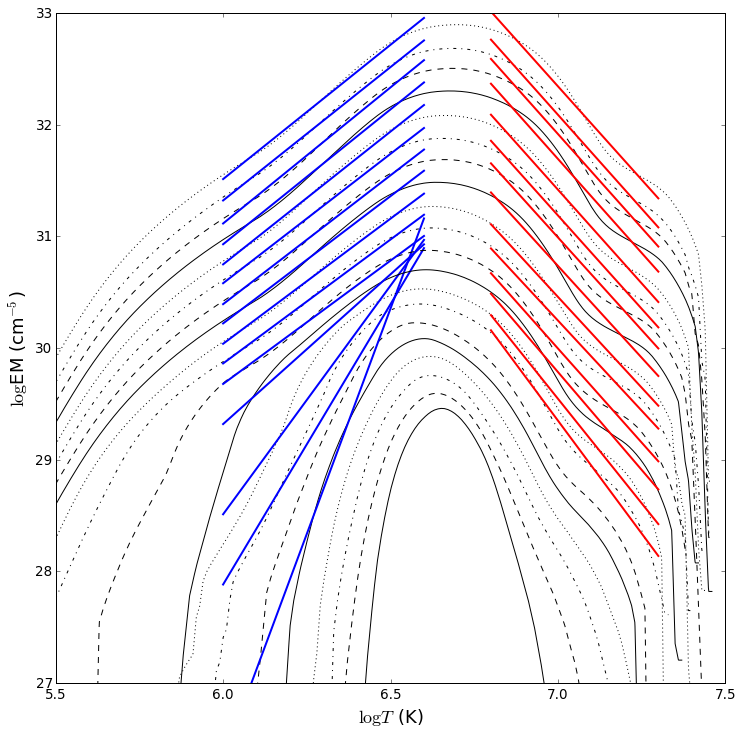

In [10]:
plotter.plot_em_curves(fit_lines=fit_lines)

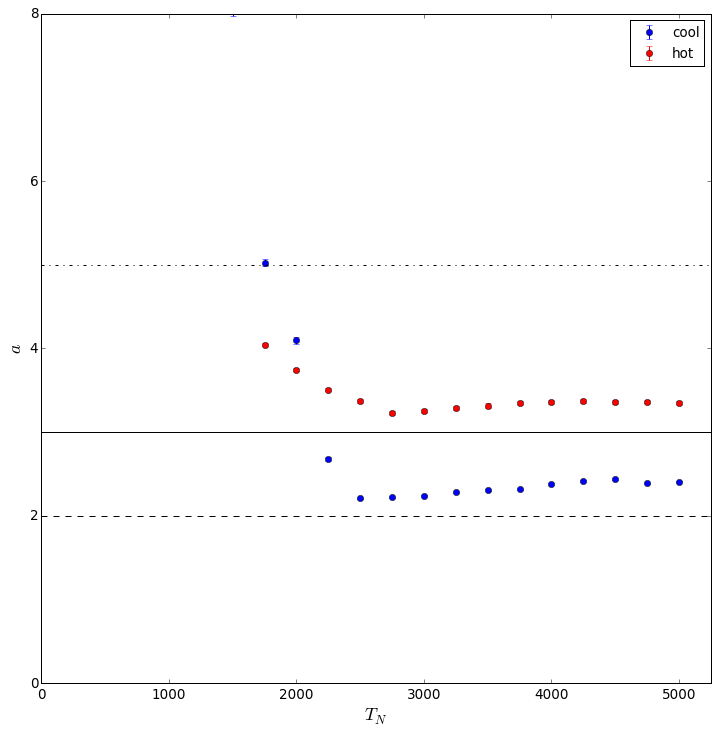

In [11]:
plotter.plot_em_slopes()

Something strange is going on with the fit uncertainty. Let's go back and calculate sigma from the original parameters and compare this to the new sigma value.

In [12]:
old_sigma = []
old_mean_temp = []
for i in range(len(process.em)):
    old_sigma.append(np.std(process.em[i],axis=0))
    old_mean_temp.append(np.mean(process.temp_em[i],axis=0))

/usr/lib/python3/dist-packages/numpy/core/_methods.py:98: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


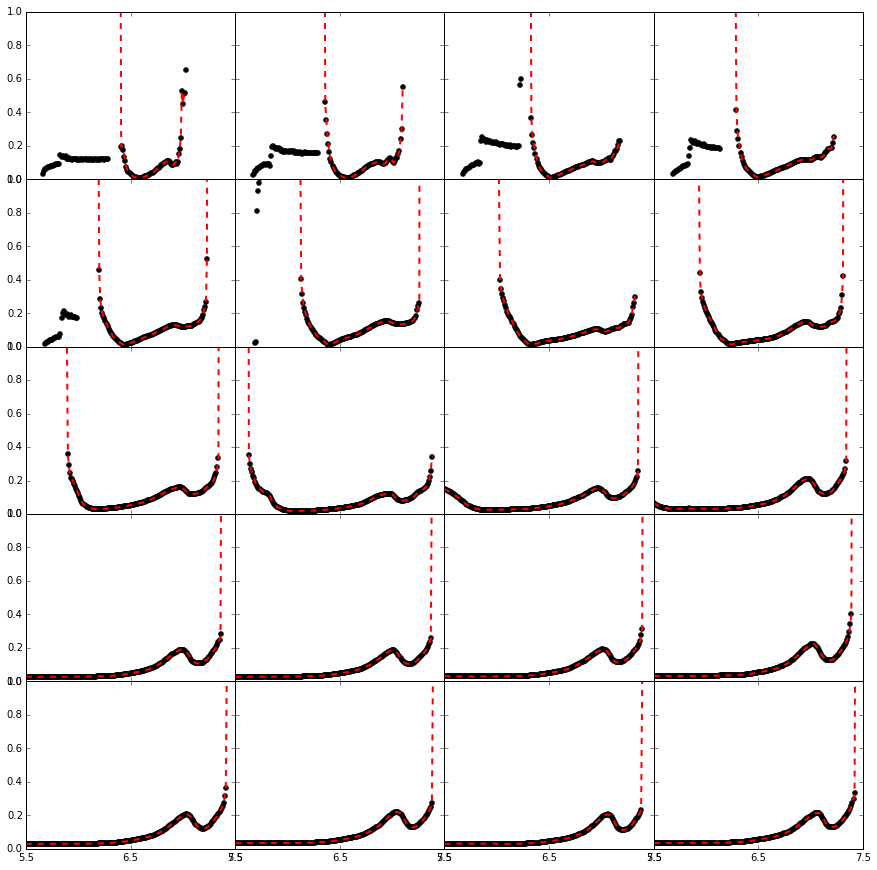

In [13]:
i = 0
fig,axes = plt.subplots(5,4,figsize=(15,15),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for ax in axes.flatten():
    ax.plot(old_mean_temp[i],old_sigma[i],'ok',markersize=5)
    ax.plot(process.temp_mean[i],process.em_std[i],'--r',linewidth=2)
    ax.set_xticks([5.5,6.5,7.5])
    ax.set_xlim([5.5,7.5])
    ax.set_ylim([0,1])
    i = i + 1

So the interpolated $\sigma$ values follow the original $\sigma$ values quite closely, except for low values of $T_N$ where we don't have any valueable fit information anyway.

##Computing $d\log{\mathrm{EM}}/d\log{T}$

Now, instead of performing a linear fit to separate branches of the $\mathrm{EM}$ curve, we will compute the derivative over the entire range of $T$.

In [30]:
def central_difference(x,y):
    dx = np.gradient(x)
    return np.gradient(y,dx)

In [31]:
d_EMd_T = []
for i in range(len(process.em_mean)):
    d_EMd_T.append(central_difference(process.temp_mean[i],process.em_mean[i]))

Now, we'll plot these values versus temperature.

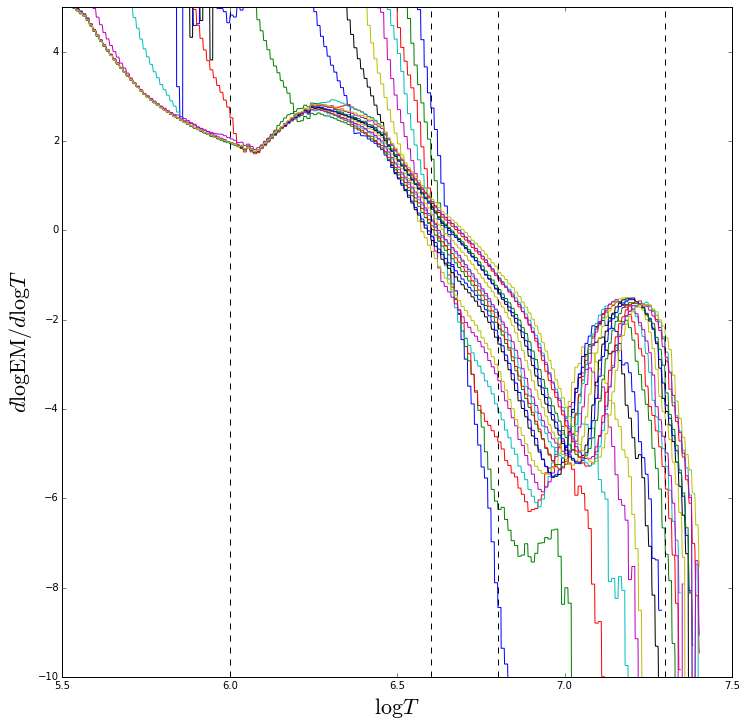

In [32]:
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
for i in range(len(d_EMd_T)):
    ax.plot(process.temp_mean[i][:-50],d_EMd_T[i][:-50])
ax.axvline(linestyle='--',color='k',x=6.0)
ax.axvline(linestyle='--',color='k',x=6.6)
ax.axvline(linestyle='--',color='k',x=6.8)
ax.axvline(linestyle='--',color='k',x=7.3)
ax.set_xlim([5.5,7.5])
ax.set_ylim([-10,5])
ax.set_xlabel(r'$\log{T}$',fontsize=22)
ax.set_ylabel(r'$d\log{\mathrm{EM}}/d\log{T}$',fontsize=22)
plt.show()

Need to come up with a way of truncating the mess at the end. Right now, I'm just choosing to exclude the last 50 points of the interpolated emission measures; be more systematic about this.